# Lidar Point Cloud Segmentation task. Iaroslav Koshelev

## Importing nesessary modules

In [1]:
import numpy as np
import torch
from os.path import join
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import time
from skimage.exposure import equalize_hist
%matplotlib inline

## Loading and transforming data

In [2]:
#Copypaste from kitti notebook
RINGS = [1.51, 1.52, 1.53, 1.54, 1.55, 1.57, 1.58, 1.59, 1.6 , 1.61,
         1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.69, 1.7 , 1.71, 1.72,
         1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.82, 1.83,
         1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.92, 1.94,
         1.95, 1.96, 1.97, 1.98]

RINGS = dict((int(100 * angle), i) for i, angle in enumerate(RINGS))

def load_frame(kitti_path, frame_id):
    
    # loading point closud, labels and calibration
    
    velodyne_path = join(kitti_path, 'velodyne', '%06d.bin' % int(frame_id))
    calib_path = join(kitti_path, 'calib', '%06d.txt' % int(frame_id))
    label_path = join(kitti_path, 'label_2', '%06d.txt' % int(frame_id))
    
    XYZI = np.fromfile(velodyne_path, np.float32).reshape(-1, 4)
    
    with open(calib_path) as src:
        calib = dict((line[0][:-1], 
                      np.array(list(map(float, line[1:]))))
                     for line in map(str.split, src) if line)
    
    with open(label_path) as src:
        labels = list((line[0], list(map(float, line[1:])))
                      for line in map(str.split, src) if line)
        
    SHPERE = np.zeros((XYZI.shape[0], XYZI.shape[1]), dtype = np.float32)
    SHPERE[:, 0] = np.sqrt(XYZI[:, 0] ** 2 + XYZI[:, 1] ** 2 + XYZI[:, 2] ** 2)
    SHPERE[:, 1] = np.arctan2(XYZI[:, 1], XYZI[:, 0])
    SHPERE[:, 2] = np.arctan2(np.sqrt(XYZI[:, 0] ** 2 + XYZI[:, 1] ** 2), XYZI[:, 2])
        
    # affine transform to camera frame
        
    R0_rect = calib['R0_rect'].reshape(3, 3)
    R0_rect = np.pad(R0_rect, [(0, 1), (0, 1)], 'constant', constant_values = 0)
    R0_rect[3, 3] = 1
        
    Tr_velo_to_cam = calib['Tr_velo_to_cam'].reshape(3, 4)
    Tr_velo_to_cam = np.pad(Tr_velo_to_cam, [(0, 1), (0, 0)], 'constant', constant_values = 0)
    Tr_velo_to_cam[3, 3] = 1
    
    affine = np.matrix(R0_rect) * np.matrix(Tr_velo_to_cam)
    
    XYZ_cam = np.ones((XYZI.shape[0], XYZI.shape[1]), dtype = np.float32)
    XYZ_cam[:, :-1] = XYZI[:, :3]
    
    XYZ_cam = (affine * XYZ_cam.T).T.A
    
    for i in range(XYZ_cam.shape[1]):
        XYZ_cam[:, i] /= XYZ_cam[:, -1]
        
    XYZ_cam = XYZ_cam[:, :-1]

    # label points according with groundtruth
    
    XYZ_labels = np.zeros((XYZI.shape[0], 1))
    
    XZ_cam = XYZ_cam[:, [0, 2]]
    
    for gt_type, gt in labels:
        
        if gt_type.lower() in {'pedestrian', 'person_sitting'}:
            label = 1
        elif gt_type.lower() in {'car', 'van'}:
            label = 2
        elif gt_type.lower() in {'cyclist'}:
            label = 3
        else:
            continue
        
        height, width, length = gt[7:10]
        x_min, x_max = - length / 2, length / 2
        y_min, y_max = gt[11] - height, gt[11] - 0.05
        z_min, z_max = - width / 2, width / 2
        
        XZ_cam_rot = XZ_cam.copy()
        
        # translation
        XZ_cam_rot[:, 0] -= gt[10]
        XZ_cam_rot[:, 1] -= gt[12]
        
        # rotation
        R = np.matrix([[np.cos(gt[13]), np.sin(gt[13])],
                       [-np.sin(gt[13]), np.cos(gt[13])]])
        
        XZ_cam_rot = XZ_cam_rot * R
        
        XYZ_cam_rot = np.concatenate((XZ_cam_rot[:, 0].reshape(-1, 1),
                                      XYZ_cam[:, 1].reshape(-1, 1), 
                                      XZ_cam_rot[:, 1].reshape(-1, 1)), axis = 1)
        
        # label points
        condition = ((XYZ_cam_rot[:, 0] >= x_min) &
                     (XYZ_cam_rot[:, 0] <= x_max) &
                     (XYZ_cam_rot[:, 1] <= y_max) &
                     (XYZ_cam_rot[:, 1] >= y_min) &
                     (XYZ_cam_rot[:, 2] >= z_min) &
                     (XYZ_cam_rot[:, 2] <= z_max))
                     
        XYZ_labels[condition] = label
        
    condition = ((- np.pi / 4 < SHPERE[:, 1]) & (SHPERE[:, 1] < np.pi / 4))
    
    # frontview
    
    SHPERE_ = SHPERE[condition, :]
    XYZI_ = XYZI[condition, :]
    XYZ_labels_ = XYZ_labels[condition, :]
    
    FRONT = -1 * np.ones((len(RINGS), 600, 6), dtype = np.float32)
    
    for i in range(len(XYZ_labels_)):
        r = RINGS.get(int(100 * np.round(SHPERE_[i, 2], 2)))
        if r is None:
            continue
        
        c = np.round((FRONT.shape[1] - 1) * (SHPERE_[i, 1] + np.pi / 4) * 2 / np.pi)

        FRONT[r, int(c), 0] = XYZI_[i, 0]
        FRONT[r, int(c), 1] = XYZI_[i, 1]
        FRONT[r, int(c), 2] = XYZI_[i, 2]
        FRONT[r, int(c), 3] = XYZI_[i, 3]
        FRONT[r, int(c), 4] = SHPERE_[i, 0]
        FRONT[r, int(c), 5] = XYZ_labels_[i, 0]
        
    return FRONT

## Preparing data (run only once to create data)

In [31]:
#Treating giant trainset and testset independently for less memory consumption.
#This block runs once and then variables are loaded from file.
def normalize_set(x):
    for i in range(np.shape(x)[0]):
        for j in range(np.shape(x)[1]):
            x[i,j,:,:] = x[i,j,:,:] - np.min(x[i,j,:,:]);
            x[i,j,:,:] = x[i,j,:,:]/np.max(x[i,j,:,:]);
    return x;
#Trainset
X_temp = [];
Y_temp = [];
for i in range(7480):
    frame = load_frame(kitti_path = './kitti/training', frame_id = i);
    X_temp.append(frame[:,:,0:5]);
    Y_temp.append(frame[:,:,5]);
X_temp = np.asarray(X_temp);
Y_temp = np.asarray(Y_temp);
X_temp = np.swapaxes(X_temp,1,3);
X_temp = np.swapaxes(X_temp,2,3);
np.save('X_temp',X_temp);
np.save('Y_temp',Y_temp);
del X_temp;
del Y_temp;
X_temp = np.load('X_temp.npy');
Y_temp = np.load('Y_temp.npy');
Y_temp2 = (Y_temp==1.0) + 2*(Y_temp==2.0) + 3*(Y_temp==3.0);
del Y_temp;
X_train = X_temp[:6500,:,:,:];
Y_train = Y_temp2[:6500,:,:];
X_val = X_temp[6500:7000,:,:,:];
Y_val = Y_temp2[6500:7000,:,:];
X_test = X_temp[7000:7480,:,:,:];
Y_test = Y_temp2[7000:7480,:,:];
del X_temp;
del Y_temp2;
X_train = normalize_set(X_train);
X_val = normalize_set(X_val);
X_test = normalize_set(X_test);
np.save('X_train',X_train);
np.save('Y_train',Y_train);
np.save('X_test',X_test);
np.save('Y_test',Y_test);
np.save('X_val',X_val);
np.save('Y_val',Y_val);

## Doubling dataset by horizontal flip (run once and futher loaded from file)

In [4]:
X_train = np.concatenate((X_train,np.flip(X_train,axis=3)));
Y_train = np.concatenate((Y_train,np.flip(Y_train,axis=2)));
np.save('X_train_doubled',X_train);
np.save('Y_train_doubled',Y_train);

## Loading dataset

In [2]:
X_test = np.load('X_test.npy');
Y_test = np.load('Y_test.npy');
X_train = np.load('X_train_doubled.npy');
Y_train = np.load('Y_train_doubled.npy');
X_val = np.load('X_val.npy');
Y_val = np.load('Y_val.npy');

## Necessary functions for learning and evaluation

In [7]:
#Intersection over union
def iou(prediction,target):
    ious = [];
    for i in range(4):
        a = prediction == i;
        b = target == i;
        intersection = np.sum(np.logical_and(a,b));
        union = np.sum(np.logical_or(a,b));
        if union == 0:
            ious.append(1.0);
        else:
            ious.append(intersection/union);
    return np.array(ious);

#Reduction of network result to single image
def reduct(y):
    tmp, ret = torch.max(y,1);
    return ret;

#Cross-Entropy loss calculation
def compute_loss_cuda(model,X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

#Batches load and iteration
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

#Training function
def train(model,X,Y,X_v,Y_v,num_epochs,batch_size):
    model.cuda()
    train_loss = []
    opt = torch.optim.Adam(model.parameters(),lr=0.01);
    #Full pass over the training data
    for epoch in range(num_epochs):
        val_accuracy = 0;
        start_time = time.time() 
        #Training network mode for dropouts and batchnorms
        model.train(True)
        for X_batch, Y_batch in iterate_minibatches(X, Y, batch_size):
            #Train on batch
            loss = compute_loss_cuda(model,X_batch, Y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.data.cpu().numpy()[0])
        #Full pass over the validation data:
        model.train(False) #Use averages for batch_norm
        i=0;
        #Saving networ parameters to file
        torch.save(model.state_dict(), './trained/seg_dict_expanded_binary_' + str(epoch+1));
        for X_batch, Y_batch in iterate_minibatches(X_v, Y_v, batch_size):
            logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
            val_accuracy = val_accuracy + iou(reduct(logits).data.cpu().numpy(),Y_batch);
            i = i + 1;

        #Printing the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X) // batch_size :])))
        print("  intersection over union:")
        print(val_accuracy/i);
        print("  mean intersection over union:")
        print(np.mean(val_accuracy/i));
    return train_loss;

## Creating SqueezeSeg https://arxiv.org/abs/1710.07368

In [3]:
#Convolution + BatchNorm  ReLU
class myconv(nn.Module):
    def __init__(self, n_in, n_out,n_ker,n_str=1,pad=0,batch=True,relu=True):
        super(myconv, self).__init__()
        self.bbatch = batch;
        self.brelu = relu;
        self.conv = nn.Conv2d(n_in, n_out, n_ker,stride=n_str,padding=pad);
        self.batch = nn.BatchNorm2d(n_out);
        self.relu = nn.ReLU(inplace=True);

    def forward(self, x):
        x = self.conv(x);
        if self.bbatch == True:
            x = self.batch(x);
        if self.brelu == True:
            x = self.relu(x);
        return x

#Deonvolution + BatchNorm  ReLU
class mydeconv(nn.Module):
    def __init__(self, n_in, n_out,n_ker,n_str=1,pad=1,batch=True,relu=True,opad=0):
        super(mydeconv, self).__init__()
        self.bbatch = batch;
        self.brelu = relu;
        self.deconv = nn.ConvTranspose2d(in_channels=n_in, out_channels=n_out, kernel_size=n_ker,stride=n_str,padding=pad,output_padding=opad);
        self.batch = nn.BatchNorm2d(n_out);
        self.relu = nn.ReLU(inplace=True);

    def forward(self, x):
        x = self.deconv(x);
        if self.bbatch == True:
            x = self.batch(x);
        if self.brelu == True:
            x = self.relu(x);
        return x

#Fire module
class myfire(nn.Module):
    def __init__(self,n_in,s11,e11,e33):
        super(myfire, self).__init__()
        self.convinit = myconv(n_in, s11, 1);
        self.conv1 = myconv(s11, e33, 3, pad=1);
        self.conv2 = myconv(s11, e11, 1);
        
    def forward(self, x):
        x = self.convinit(x);
        x1 = self.conv1(x);
        x2 = self.conv2(x);
        return torch.cat([x1, x2],dim=1);

#Fire upscaling module
class myfireup(nn.Module):
    def __init__(self,n_in,s11,e11,e33,scale=(1,2),outpad=0):
        super(myfireup, self).__init__()
        self.convinit = myconv(n_in, s11, 1);
        self.decup = mydeconv(s11,s11,3,n_str=scale,opad=outpad);
        self.conv1 = myconv(s11, e33, 3, pad=1);
        self.conv2 = myconv(s11, e11, 1);
        
    def forward(self, x):
        x = self.convinit(x);
        x = self.decup(x);
        x1 = self.conv1(x);
        x2 = self.conv2(x);
        return torch.cat([x1, x2],dim=1);

#Network itself
class SqueezeSeg(nn.Module):
    def __init__(self):
        super(SqueezeSeg, self).__init__()
        self.conv1a = myconv(5,64,3,2,1);
        self.conv1b = myconv(5,64,1);
        self.pool1 = nn.MaxPool2d(kernel_size=(1,3), stride=(1,2),padding=(0,1));
        self.fire2 = myfire(64,16,64,64);
        self.fire3 = myfire(128,16,64,64);
        self.pool3 = nn.MaxPool2d(kernel_size=(1,3), stride=(1,2),padding=(0,1));
        self.fire4 = myfire(128,32,128,128);
        self.fire5 = myfire(256,32,128,128);
        self.pool5 = nn.MaxPool2d(kernel_size=(1,3), stride=(1,2),padding=(0,1));
        self.fire6 = myfire(256,48,192,192);
        self.fire7 = myfire(384,48,192,192);
        self.fire8 = myfire(384,64,256,256);
        self.fire9 = myfire(512,64,256,256);
        self.fire10dec = myfireup(512,64,128,128);
        self.fire11dec = myfireup(256,32,64,64,outpad=(0,1));
        self.fire12dec = myfireup(128,16,32,32,outpad=(0,1));
        self.fire13dec = myfireup(64,16,32,32,scale=(2,2),outpad=(0,1));
        self.conv14 = nn.Conv2d(in_channels=64, out_channels=4, kernel_size=3,stride=1,padding=1);
        self.relu = nn.LeakyReLU(inplace=True);

    def forward(self, x):
        x1 = self.conv1b(x);
        #return x1; #64x43x600
        x2 = self.conv1a(x);
        #return x2; #64x22x300
        x = self.pool1(x2);
        #return x;  #64x22x150
        x3 = self.fire2(x);
        #return x3; #128x22x150
        x = self.fire3(x3);
        #return x;  #128x22x150
        x = self.pool3(x);
        #return x;  #128x22x75
        x4 = self.fire4(x);
        #return x4; #256x22x75
        x = self.fire5(x4);
        #return x;  #256x22x75
        x = self.pool5(x);
        #return x;  #256x22x38
        x = self.fire6(x);
        #return x;  #384x22x38
        x = self.fire7(x);
        #return x;  #384x22x38
        x = self.fire8(x);
        #return x;  #512x22x38
        x = self.fire9(x);
        #return x;  #512x22x38
        x = self.fire10dec(x);
        #return x;  #256x22x75
        x = x + x4;
        #return x;  #256x22x75
        x = self.fire11dec(x);
        #return x;  #128x22x150
        x = x + x3;
        #return x;  #128x22x150
        x = self.fire12dec(x);
        #return x;  #64x22x300
        x = x + x2;
        #return x;  #64x22x300
        x = self.fire13dec(x);
        #return x;  #64x43x600
        x = x + x1;
        #return x;  #64x43x600
        x = self.conv14(x);
        #return x;  #4x43x600
        x = self.relu(x);
        return x;

In [4]:
seg = SqueezeSeg();
seg.cuda();

## Training with cross-entropy loss (very long)

In [9]:
loss = train(seg,X_train,Y_train,X_val,Y_val,200,10);

Epoch 1 of 200 took 182.553s
  training loss (in-iteration): 	0.095400
  intersection over union:
[0.97834502 0.04       0.62277115 0.24      ]
  mean intersection over union:
0.47027904409327553
Epoch 2 of 200 took 180.164s
  training loss (in-iteration): 	0.058572
  intersection over union:
[0.97952278 0.10110924 0.64840373 0.26      ]
  mean intersection over union:
0.49725893704299895
Epoch 3 of 200 took 179.918s
  training loss (in-iteration): 	0.052139
  intersection over union:
[0.98097137 0.27865533 0.66318977 0.14      ]
  mean intersection over union:
0.5157041188832274
Epoch 4 of 200 took 179.809s
  training loss (in-iteration): 	0.047646
  intersection over union:
[0.98204654 0.31251662 0.68949439 0.16      ]
  mean intersection over union:
0.5360143863315094
Epoch 5 of 200 took 179.628s
  training loss (in-iteration): 	0.045983
  intersection over union:
[0.98170713 0.27565158 0.69446358 0.2       ]
  mean intersection over union:
0.5379555705494566
Epoch 6 of 200 took 179

Epoch 43 of 200 took 179.053s
  training loss (in-iteration): 	0.026755
  intersection over union:
[0.98824095 0.47932237 0.77725138 0.17314167]
  mean intersection over union:
0.6044890926842557
Epoch 44 of 200 took 179.064s
  training loss (in-iteration): 	0.026573
  intersection over union:
[0.9875573  0.44411807 0.77764218 0.19297596]
  mean intersection over union:
0.6005733796788073
Epoch 45 of 200 took 179.036s
  training loss (in-iteration): 	0.026534
  intersection over union:
[0.98832956 0.50424726 0.77963972 0.25817634]
  mean intersection over union:
0.6325982199081307
Epoch 46 of 200 took 179.043s
  training loss (in-iteration): 	0.026411
  intersection over union:
[0.98852134 0.46576541 0.78398411 0.17345374]
  mean intersection over union:
0.6029311525339183
Epoch 47 of 200 took 179.092s
  training loss (in-iteration): 	0.026183
  intersection over union:
[0.98863635 0.50253958 0.78832384 0.26004358]
  mean intersection over union:
0.6348858352488522
Epoch 48 of 200 took

Epoch 85 of 200 took 179.067s
  training loss (in-iteration): 	0.022146
  intersection over union:
[0.98784777 0.51711803 0.76969565 0.31317455]
  mean intersection over union:
0.6469590017096779
Epoch 86 of 200 took 179.080s
  training loss (in-iteration): 	0.022009
  intersection over union:
[0.98871286 0.57163111 0.78390273 0.42731025]
  mean intersection over union:
0.692889235250426
Epoch 87 of 200 took 179.080s
  training loss (in-iteration): 	0.021518
  intersection over union:
[0.98877805 0.51601268 0.78924462 0.35480835]
  mean intersection over union:
0.6622109258825508
Epoch 88 of 200 took 179.060s
  training loss (in-iteration): 	0.021449
  intersection over union:
[0.98874951 0.50970595 0.78543739 0.39167542]
  mean intersection over union:
0.6688920711771911
Epoch 89 of 200 took 179.030s
  training loss (in-iteration): 	0.021927
  intersection over union:
[0.98900019 0.59261058 0.79605864 0.32258823]
  mean intersection over union:
0.675064412937222
Epoch 90 of 200 took 1

Epoch 127 of 200 took 179.034s
  training loss (in-iteration): 	0.018888
  intersection over union:
[0.98932076 0.58138232 0.80484007 0.36589626]
  mean intersection over union:
0.6853598522518125
Epoch 128 of 200 took 179.072s
  training loss (in-iteration): 	0.019913
  intersection over union:
[0.98879642 0.56220784 0.78882108 0.40249318]
  mean intersection over union:
0.6855796323098624
Epoch 129 of 200 took 179.106s
  training loss (in-iteration): 	0.019424
  intersection over union:
[0.98943669 0.54848322 0.79343978 0.41684547]
  mean intersection over union:
0.687051289350873
Epoch 130 of 200 took 179.079s
  training loss (in-iteration): 	0.019160
  intersection over union:
[0.98945345 0.52643005 0.80392498 0.38112791]
  mean intersection over union:
0.6752340993781627
Epoch 131 of 200 took 179.059s
  training loss (in-iteration): 	0.019549
  intersection over union:
[0.98913069 0.57410272 0.78634428 0.46643841]
  mean intersection over union:
0.704004024516292
Epoch 132 of 200 

Epoch 169 of 200 took 179.000s
  training loss (in-iteration): 	0.018125
  intersection over union:
[0.98885855 0.54492587 0.78732045 0.35760158]
  mean intersection over union:
0.6696766118423207
Epoch 170 of 200 took 179.058s
  training loss (in-iteration): 	0.018676
  intersection over union:
[0.98936168 0.5938091  0.80347628 0.47590923]
  mean intersection over union:
0.715639071600676
Epoch 171 of 200 took 179.092s
  training loss (in-iteration): 	0.017831
  intersection over union:
[0.98936556 0.60872529 0.79395638 0.36869844]
  mean intersection over union:
0.690186416878396
Epoch 172 of 200 took 179.065s
  training loss (in-iteration): 	0.017759
  intersection over union:
[0.98930084 0.56612534 0.79322335 0.35618445]
  mean intersection over union:
0.6762084946602278
Epoch 173 of 200 took 179.080s
  training loss (in-iteration): 	0.018595
  intersection over union:
[0.98937213 0.59453266 0.80519604 0.39758487]
  mean intersection over union:
0.6966714243462342
Epoch 174 of 200 

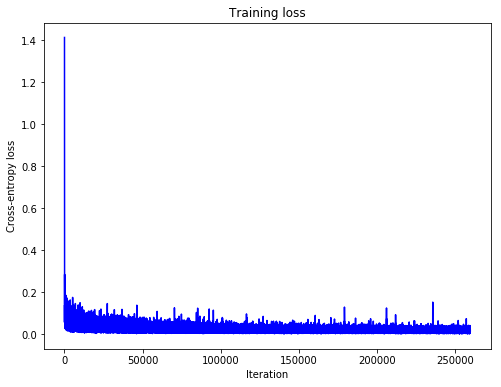

In [19]:
plt.figure(figsize=(8,6));
plt.title("Training loss");
plt.xlabel("Iteration");
plt.ylabel("Cross-entropy loss");
plt.plot(loss,'b');
plt.show();

## Best results on validation set achieved during training

Epoch 185 of 200 took 179.049s
    
    training loss (in-iteration) {//on training set}: 	0.017654 

    intersection over union {//on validation set in order [background; pedestrian,person sitting; car,van; cyclist]}:

[0.98938381 0.62845889 0.79383524 0.50721101] 

    mean intersection over union {//over all classes on validation set}:

0.7297222393547029

## Loading best network parameters and evaluating on test set

In [8]:
seg.load_state_dict(torch.load('./trained/seg_dict_expanded_185'));
seg.train(False);
i = 0;
val_accuracy = 0;
for X_batch, Y_batch in iterate_minibatches(X_test, Y_test, 10):
    logits = seg(Variable(torch.FloatTensor(X_batch)).cuda())
    val_accuracy = val_accuracy + iou(reduct(logits).data.cpu().numpy(),Y_batch);
    i = i + 1;
print("Intersection over union [background; pedestrian,person sitting; car,van; cyclist]:")
print(val_accuracy/i);
print("mean intersection over union (over all classes):")
print(np.mean(val_accuracy/i));

Intersection over union:
[0.98924614 0.67098417 0.79141646 0.46965866]
mean intersection over union:
0.7303263541808358


## Visualization of network results on test set and evaluation time per one frame
### 0 - background
### 1- pedestrian, person_sitting
### 2 - car, van 
### 2 - cyclist 

Evaluation time per one picture (sec):
0.0028075695037841795


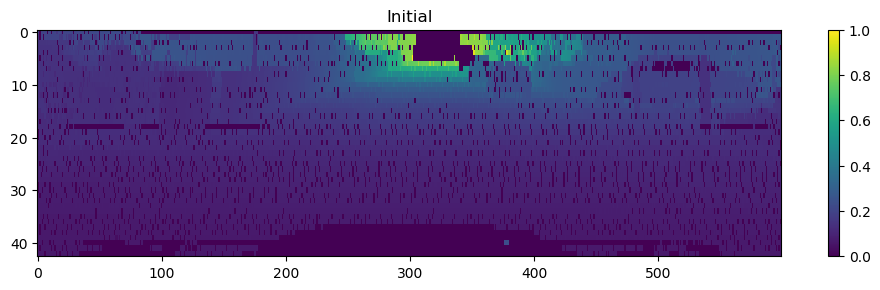

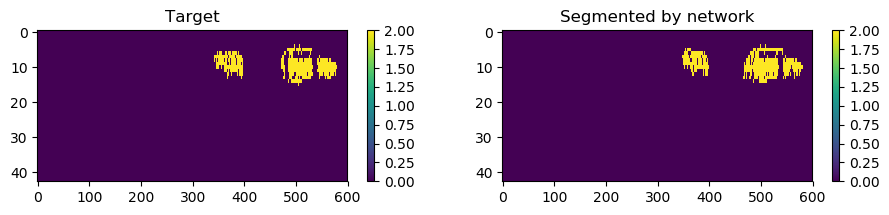

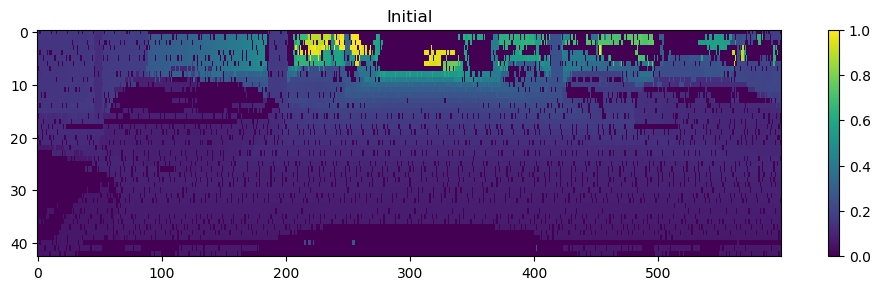

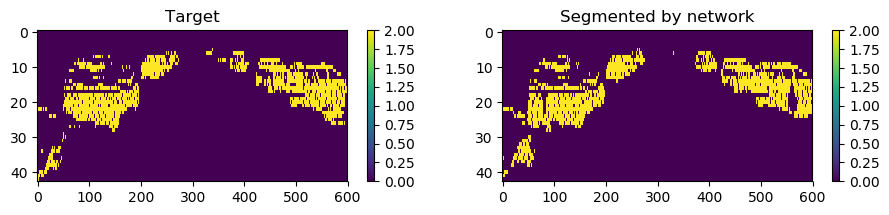

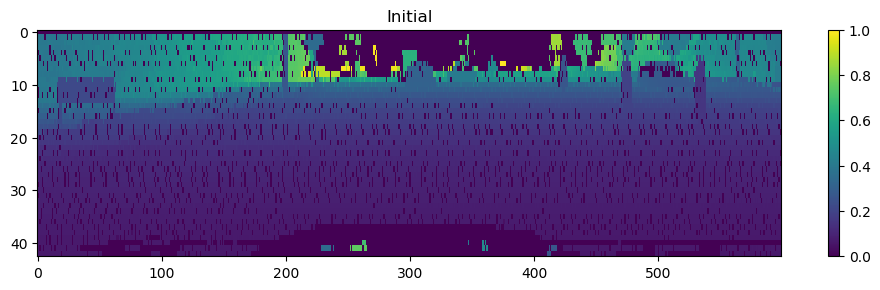

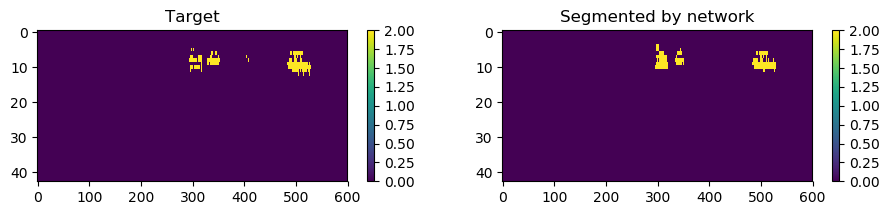

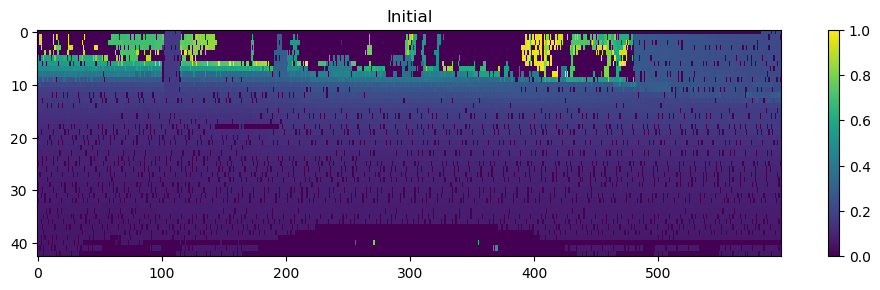

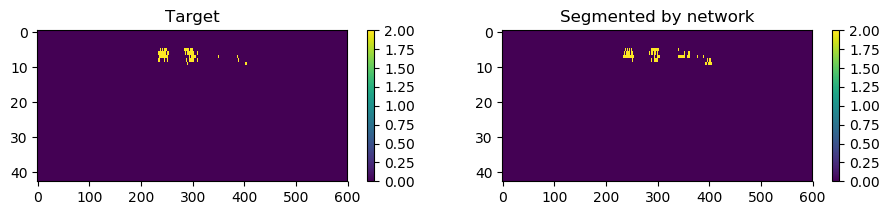

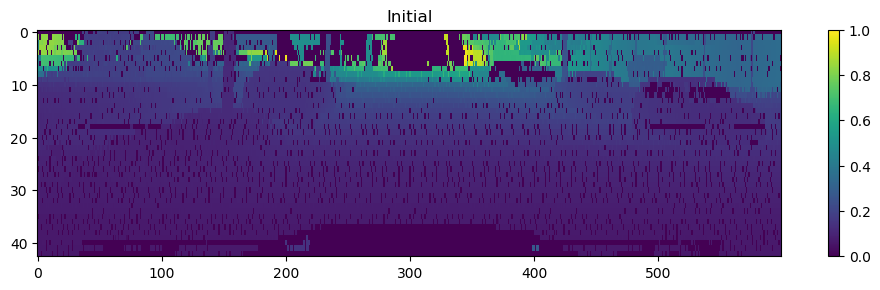

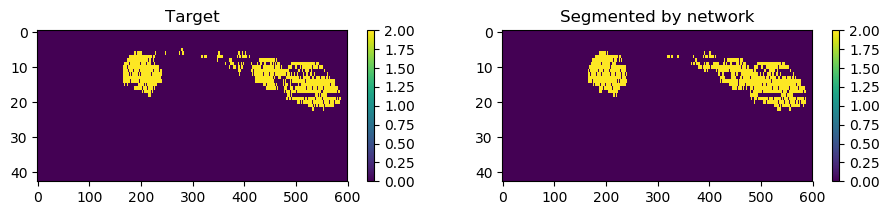

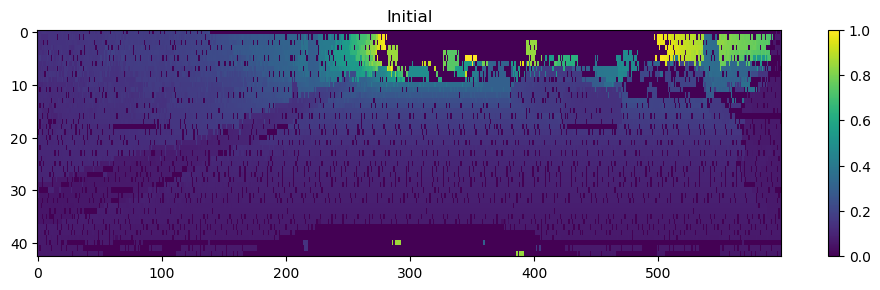

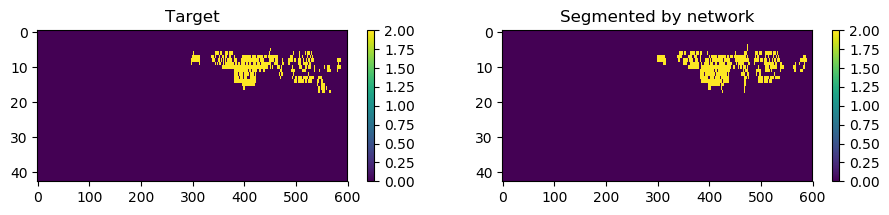

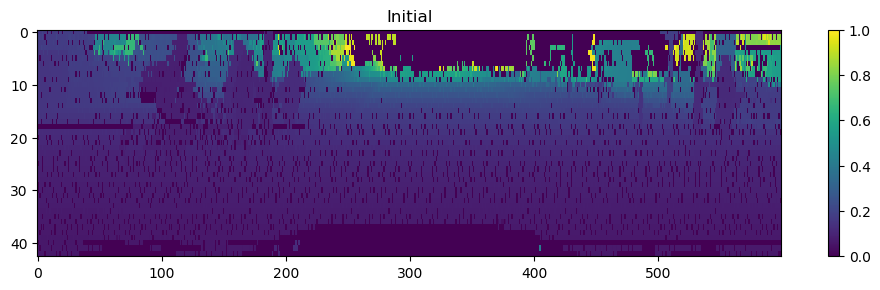

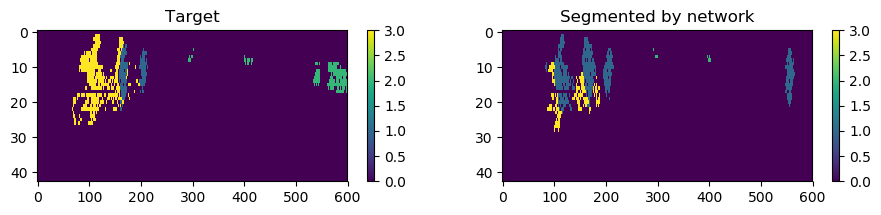

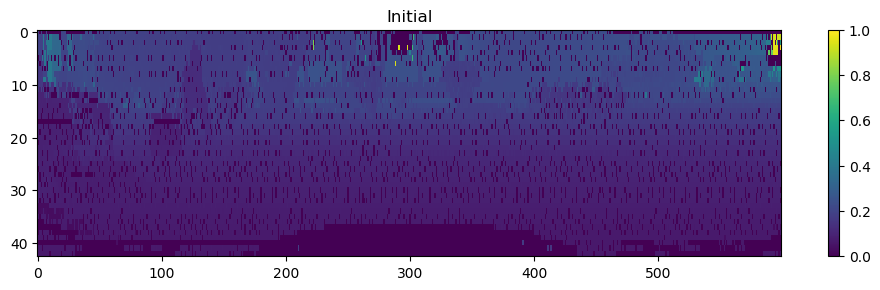

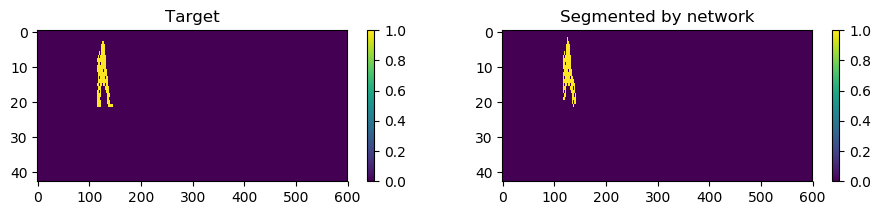

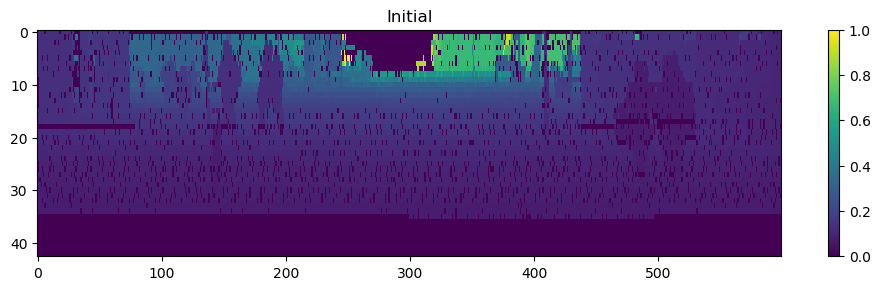

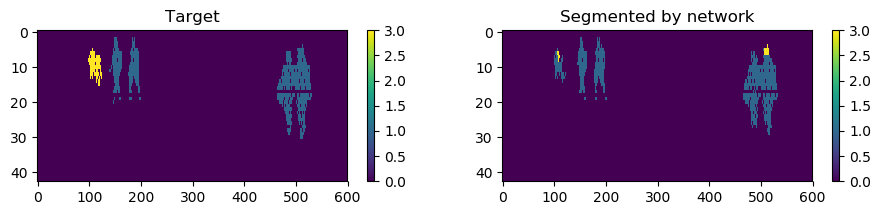

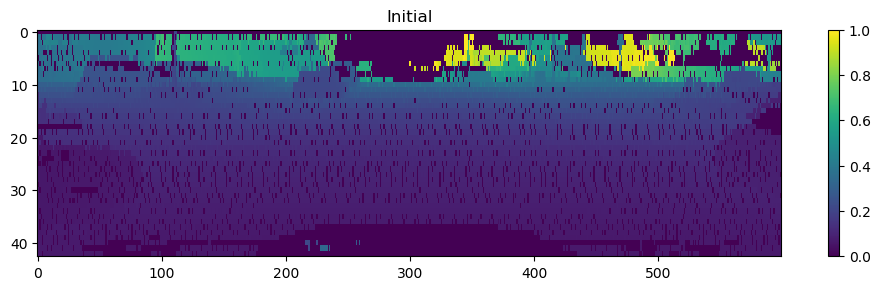

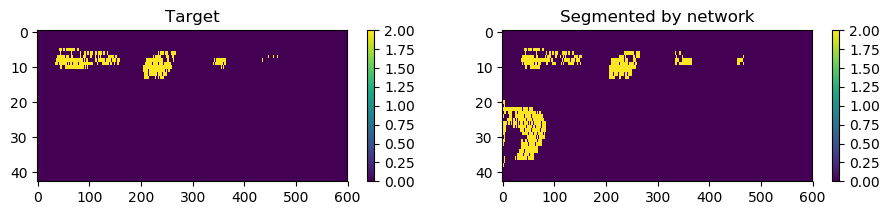

In [8]:
start_time = time.time(); 
a = seg(Variable(torch.FloatTensor(X_test[10:20,:,:,:])).cuda());
stop_time = time.time();
print("Evaluation time per one picture (sec):");
print((stop_time - start_time)/10);
for i in range(10):
    plt.figure(num=None, figsize=(12,3),dpi=100);
    plt.imshow((X_test[10+i,4,:,:]),aspect='auto');
    plt.title("Initial")
    plt.colorbar();
    fig = plt.figure(num=None, figsize=(11,2),dpi=100)
    plt.subplot(121)
    plt.imshow((Y_test[10+i,:,:]),aspect='auto');
    plt.title("Target")
    plt.colorbar();
    plt.subplot(122)
    plt.imshow((reduct(a).data.cpu().numpy()[i,:,:]),aspect='auto');
    plt.title("Segmented by network")
    plt.colorbar();
    plt.show()

# Conclusions:
## - Built and trained kind-of SqueezeSeg network for classifying lidar images (consisting of 5 layers: x,y,z,I,r) per 4 classes (including background)
## - Achieved segmentation performance (IoU) on test set:
## -- Background: 98.9 %
## -- Pedestrian or person sitting: 67.1%
## -- Car or van: 79.1%
## -- Cyclist: 47.0%
## -- Total mean IoU: 73.0%
## - Achieved segmentation speed per one frame (only network evaluation without preparing data frame): 2.8 ms

### Done and trained at Skoltech with NVIDIA GeForce GTX 970 by Iaroslav Koshelev